In [143]:
import sk_dsp_comm.fec_conv as fec
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import numpy as np
import pytest
import math

In [144]:
my_data = np.genfromtxt("./tfMatrix_3.csv", delimiter=";")
mat_complex = my_data[:,0::2] + 1j * my_data[:,1::2]

## What is the size of the matrix ?

In [145]:
print(f"Matrix size: {mat_complex.shape[0]} x {mat_complex.shape[1]}")

Matrix size: 14 x 1024


The matrix is of size $14 \times 1024$. The signal is divided in time/frequency, we have 1024 subcarries divided in 14 symbols per frame.

## Getting allocated subcarriers

$N_{re} = 624$

$N = 1024$

$S_1 = 1 : 312$

$S_2 = 713 : 1024$

$S_a = {S_1}\bigcup{S_2} = 1 : 312 ; 713 : 1024$

In [146]:
tfMatrix_short = np.hstack((mat_complex[:, 1:313], mat_complex[:, 712:1024]))
tfMatrix_short.shape

(14, 624)

## Matrix power distribution

In [147]:
def powerDistributionGraph(Z, abs_bias = True):
    """
    Draw the power distribution graph
    """
    if abs_bias:
        Z = abs(Z)
    fig, ax = plt.subplots()
    cs = ax.contourf(np.linspace(0, len(Z[0]), len(Z[0])), np.linspace(0, len(Z), len(Z)), Z, levels=0)
    cbar = fig.colorbar(cs)
    ax.set_xlabel("Subcarriers frequencies")
    ax.set_ylabel("Symbols")
    ax.set_title("Grid position system")

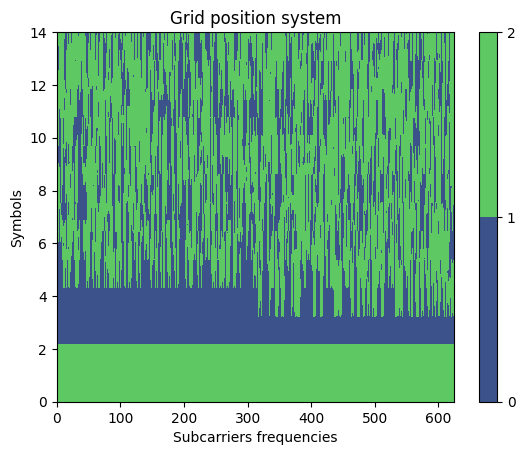

In [148]:
powerDistributionGraph(tfMatrix_short)

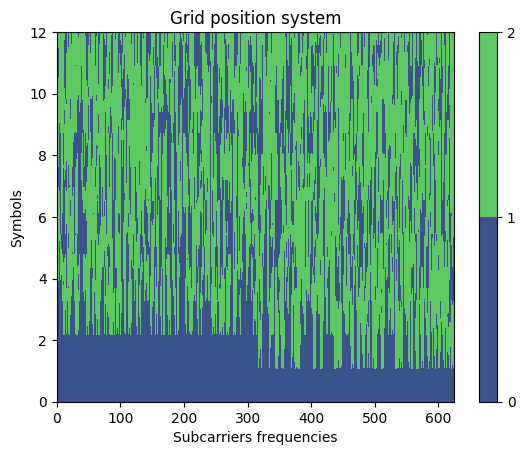

In [149]:
# Removing PSCH and SSCH channels
qamMatrix = tfMatrix_short[2:,:]
powerDistributionGraph(qamMatrix)

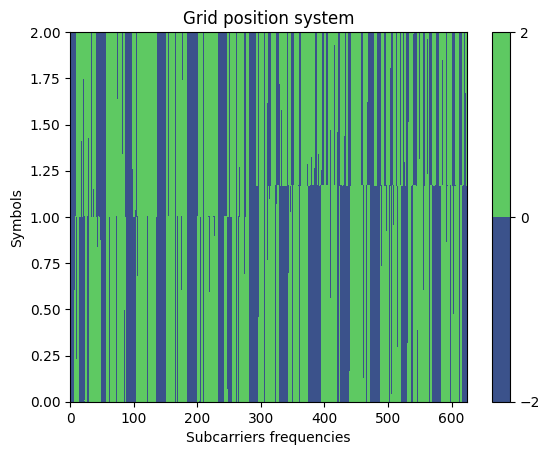

In [150]:
pbchChannel = qamMatrix[0,:]
# Display the first and second channels
powerDistributionGraph(qamMatrix[0:2,:], False)

In [151]:
def bpsk_demod(qamSeq: np.ndarray):
    sequence = []
    for i in qamSeq:
        sequence.append(1 if np.real(i) > 0 else 0)
    return sequence

In [152]:
pbch = bpsk_demod(pbchChannel)
cell_users_informations_enc = bpsk_demod(pbch)[:48]

In [153]:
def hamming748_decode(bitSeq):
    H = np.array([
        [0, 0, 0, 1, 1, 1, 1],
        [0, 1, 1, 0, 0, 1, 1],
        [1, 0, 1, 0, 1, 0, 1]
    ])

    corrected = []

    for i in range(0, len(bitSeq), 8):
        partition = bitSeq[i:i+8]
        E = np.matmul(H, bitSeq[i:i+7])
        E = np.mod(E, 2)
        error_idx = E[0]*4 + E[1]*2 + E[2]
        
        if error_idx != 0:
            error_idx -= 1
            print(f"Error detected (idx={error_idx})")
            partition = partition
            if partition[error_idx] == 1:
                partition[error_idx] = 0
            else:
                partition[error_idx] = 1
            print(f"{partition} ===> {partition}")
        
        s = sum(bitSeq[i:i+7]) % 2
        parity = bitSeq[i+7]
        if s != parity:
            print(f"Unrecoverable problem detected (parity={parity}) (sum={s})")
        
        corrected.append(partition[0])
        corrected.append(partition[1])
        corrected.append(partition[2])
        corrected.append(partition[3])
    
    return corrected

In [154]:
cell_users_informations = hamming748_decode(cell_users_informations_enc)

In [155]:
def bin2dec(nb):
    n = "0b"
    for b in nb:
        n = n + str(b)
    return int(n, 2)

In [156]:
cell_id = bin2dec(cell_users_informations[:18])
nb_users = bin2dec(cell_users_informations[18:])
print(f"Cell id={cell_id} Nb users={nb_users}")

Cell id=12345 Nb users=18


In [157]:
def parse_pbchu(payload):
    offset = 0
    user_id = payload[offset:offset+8]
    offset += 8
    mcs = payload[offset:offset+2]
    offset += 2
    start_symb = payload[offset:offset+4]
    offset += 4
    start_rb = payload[offset:offset+6]
    offset += 6
    harq = payload[offset:offset+4]
    return {
        "user_id": bin2dec(user_id),
        "mcs": bin2dec(mcs),
        "start_symbol": bin2dec(start_symb),
        "start_rb": bin2dec(start_rb),
        "harq": bin2dec(harq)
    }

In [158]:
pbch = bpsk_demod(qamMatrix.flatten('C'))
pbchu = dict()
for i in range(0, nb_users):
    decode_pbchu = hamming748_decode(pbch[48*i:48*(i + 1)])
    pbchu_parsed = parse_pbchu(decode_pbchu)
    pbchu.update({
        pbchu_parsed["user_id"]: pbchu_parsed 
    })
pbchu

{12: {'user_id': 12, 'mcs': 0, 'start_symbol': 3, 'start_rb': 37, 'harq': 2},
 7: {'user_id': 7, 'mcs': 2, 'start_symbol': 4, 'start_rb': 25, 'harq': 0},
 4: {'user_id': 4, 'mcs': 2, 'start_symbol': 4, 'start_rb': 28, 'harq': 0},
 15: {'user_id': 15, 'mcs': 2, 'start_symbol': 4, 'start_rb': 31, 'harq': 0},
 14: {'user_id': 14, 'mcs': 2, 'start_symbol': 4, 'start_rb': 34, 'harq': 0},
 16: {'user_id': 16, 'mcs': 2, 'start_symbol': 4, 'start_rb': 37, 'harq': 0},
 5: {'user_id': 5, 'mcs': 2, 'start_symbol': 4, 'start_rb': 40, 'harq': 0},
 9: {'user_id': 9, 'mcs': 2, 'start_symbol': 4, 'start_rb': 43, 'harq': 0},
 1: {'user_id': 1, 'mcs': 2, 'start_symbol': 4, 'start_rb': 46, 'harq': 0},
 10: {'user_id': 10, 'mcs': 2, 'start_symbol': 4, 'start_rb': 49, 'harq': 0},
 11: {'user_id': 11, 'mcs': 2, 'start_symbol': 4, 'start_rb': 52, 'harq': 0},
 17: {'user_id': 17, 'mcs': 2, 'start_symbol': 5, 'start_rb': 3, 'harq': 0},
 13: {'user_id': 13, 'mcs': 2, 'start_symbol': 5, 'start_rb': 6, 'harq': 0}

In [159]:
def qpsk_demod(matrix: np.ndarray):
    demod = []
    for i in matrix:
        bit_a = 0 if np.real(i) < 0 else 1
        bit_b = 0 if np.imag(i) < 0 else 1
        demod.append(bit_a)
        demod.append(bit_b)
    return demod

In [160]:
def qam16_demod(input_sequence):
    # %FIXME Scaling vector 
    input_sequence = input_sequence * math.sqrt(2/3*(16-1))
    # Need to switch to vector 
    input_sequence = np.matrix.flatten(input_sequence)
    # Instantiate an empty list
    output_sequence = []
    # Decoding each element 
    for elem in input_sequence:
        # --- Real part decision 
        if np.real(elem) < -  2:
            bit1 = 1
            bit3 = 0
        elif  np.real(elem) < 0:
            bit1 = 1
            bit3 = 1
        elif  np.real(elem) < 2:
            bit1 = 0
            bit3 = 1
        else:
            bit1 = 0
            bit3 = 0

        # Imag part 
        if np.imag(elem) < -2:
            bit2 = 1
            bit4 = 0
        elif  np.imag(elem) < 0:
            bit2 = 1
            bit4 = 1
        elif  np.imag(elem) < 2:
            bit2 = 0
            bit4 = 1
        else:
            bit2 = 0
            bit4 = 0
        output_sequence.append(bit1)
        output_sequence.append(bit2)
        output_sequence.append(bit3)
        output_sequence.append(bit4)
    return output_sequence

In [161]:
def decode_pdcchu(start_symbol: int, start_rb: int, mcs_flag: int):
    demod = None
    if mcs_flag in [0, 1]:
        # Use BPSK
        nb_symbols = 72
        demod = bpsk_demod(tfMatrix_short[start_symbol-1, (start_rb-1)*12:(start_rb-1)*12 + nb_symbols])
    elif mcs_flag in [2, 3]:
        # Use QPSK
        nb_symbols = 36
        demod = qpsk_demod(tfMatrix_short[start_symbol-1, (start_rb-1)*12:(start_rb-1)*12 + nb_symbols])
    else:
        # Unsupported
        raise Exception(f"Unsupported MCS flag (MCS: {mcs_flag})")
    return hamming748_decode(demod)

In [162]:
def parse_pdcchu(payload):
    offset = 0
    user_id = payload[offset:offset+8]
    offset += 8
    mcs = payload[offset:offset+6]
    offset += 6
    start_symbol = payload[offset:offset+4]
    offset += 4
    start_rb = payload[offset:offset+6]
    offset += 6
    rb_size = payload[offset:offset+10]
    offset += 10
    crc = payload[offset:offset+2]
    return {
        "user_id": bin2dec(user_id),
        "mcs": bin2dec(mcs),
        "start_symbol": bin2dec(start_symbol),
        "start_rb": bin2dec(start_rb),
        "rb_size": bin2dec(rb_size),
        "crc": bin2dec(crc)
    }

In [163]:
USER = 7

start_symbol = pbchu[USER]["start_symbol"]
start_rb = pbchu[USER]["start_rb"]
mcs = pbchu[USER]["mcs"]

pdcchu_user = decode_pdcchu(start_symbol, start_rb, mcs)
parsed_pdcchu = parse_pdcchu(pdcchu_user)
parsed_pdcchu

{'user_id': 7,
 'mcs': 7,
 'start_symbol': 5,
 'start_rb': 27,
 'rb_size': 27,
 'crc': 0}

In [164]:
def PDSCH_demod(qamSeq, mcs: int):
    demod = None
    if mcs == 0 or  mcs % 5 == 0:
        # BPSK
        demod = bpsk_demod(qamSeq)
    elif (mcs - 1) == 0 or (mcs - 1) % 5 == 0:
        # QPSK
        demod = qpsk_demod(qamSeq)
    elif (mcs - 2) == 0 or (mcs - 2) % 5 == 0:
        # 16-QAM
        demod = qam16_demod(qamSeq)
    else:
        raise Exception(f"Unsupported demodulation flag ({mcs})")
    return demod

In [165]:
def PDSCH_fec(qamSeq, mcs: int):
    deconv = None
    if mcs in [5, 6, 7, 8, 9]:
        # Rate 1/2
        deconv = fec.FECConv(("1011011", "1111001"), 6).viterbi_decoder(np.array(qamSeq).astype(int), "hard")
    elif mcs in [25, 26, 27, 28, 29]:
        # Hamming 748
        deconv = hamming748_decode(qamSeq)
    else:
        raise Exception(f"Unsupported mcs ({mcs})")
    return deconv

In [166]:
""" Apply the Cesar transformation to the ASCII input to perform (trivial) decoding 
""" 
def cesarDecode(userIdent,messEnc): 
    cesarKey = getCesarKey(userIdent)
    mess = []
    for elem in messEnc:
        rr = (elem - cesarKey)%(0xFF)
        mess.append(rr)
    return mess 


""" Convert a binary array into a Byte arrays 
"""
def bitToByte(array):
    mess = []
    nbWord = math.floor(len(array) / 8)
    for n in range(nbWord):
        w = 0
        for k in range(8):
            w += array[ n * 8 + k ] * 2**k
        mess.append(w)
    return mess 

""" Convert a byte array into a comprehensive string """
def toASCII(mess):
    word = []
    for x in mess:
        word.append(chr(int(x)))
    return word 


def getCesarKey(userId):
    # We have hard coded an interleaver between 1 and 26 and then we modulo 
	# Not using Cesar key system 
    cesarVect =   [5,
                   6,
                   10,
                   23,
                   18,
                   3,
                   9,
                   14,
                   2,
                   13,
                   8,
                   17,
                   0,
                   12,
                   4,
                   22,
                   11,
                   7,
                   20,
                   25,
                   15,
                   19,
                   24,
                   21,
                   1,
                   16];
    return cesarVect[(userId-1)%26]

In [167]:
start_symbol = parsed_pdcchu["start_symbol"]
start_rb = parsed_pdcchu["start_rb"]
rb_size = parsed_pdcchu["rb_size"]
mcs = parsed_pdcchu["mcs"]

demod_pdsch = PDSCH_demod(tfMatrix_short.flatten('C')[(start_symbol - 1) * 624 + (start_rb-1)*12:(start_symbol - 1) * 624 + (start_rb-1)*12 + (12 * rb_size)], mcs)
deconv_pdsch = PDSCH_fec(demod_pdsch, mcs)
decode_cesar = cesarDecode(USER, bitToByte(deconv_pdsch))
"".join(toASCII(decode_cesar))

'User 7: your key is 33\nNever gonna give you up\nNever gonna let you down\n ...\nNeð'